In [2]:
! pip install agate

  Using cached https://files.pythonhosted.org/packages/92/77/ef675f16486884ff7f77f3cb87aafa3429c6bb869d4d73ee23bf4675e384/agate-1.6.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9b/9f/b36f7774ff5ea8e428fdcfc4bb332c39ee5b9362ddd3d40d9516a55221b2/isodate-0.6.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1b/b4/afd75551a3b910abd1d922dbd45e49e5deeb4d47dc50209ce489ba9844dd/pytimeparse-1.1.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/f4/692a53df6708caca1c6d088c6d9003940f164f98bd9df2bdc86233641e9c/leather-0.3.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2c/60/f2af68eb046c5de5b1fe6dd4743bf42c074f7141fe7b2737d3061533b093/Babel-2.7.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/79/42/d717cc2b4520fb09e45b344b1b0b4e81aa672001dd128c180fabc655c341/text_unidecode-1.2-py2.py3-none-any.whl


In [3]:
import agate
import os, csv, re

# Temperature and crime

Using weather data and crime data, can we find out whether there has historically been more crime on warmer days in St. Louis?

We will load and filter crime data, load and filter weather data, put them together and generate a chart.

## Load the crime data

I've previously downloaded monthly crime reports from the St. Louis Metropolitan Police Department website. I've trimmed them by crime code to just the ones we're interested in: UCR codes 10000 to 40000. Then I exported those into a .csv file.

Here we're going to load them into a table in a data analysis library called agate.

In [5]:
violent_crimes = agate.Table.from_csv('violent_crimes.csv')

Let's take a look at the table, ordered by date.

In [6]:
violent_crimes.order_by('Date', reverse=True).print_table()

print('\nThere are {:,} crimes in the dataset.'.format(violent_crimes.aggregate(agate.Sum('Count'))))

|                Date | Count |  Crime | Description          |
| ------------------- | ----- | ------ | -------------------- |
| 2018-04-30 22:26:00 |     1 | 41,011 | AGG.ASSAULT-FIREA... |
| 2018-04-30 22:26:00 |     1 | 41,011 | AGG.ASSAULT-FIREA... |
| 2018-04-30 22:26:00 |     1 | 41,021 | AGG.ASSAULT-FIREA... |
| 2018-04-30 22:26:00 |     1 | 41,021 | AGG.ASSAULT-FIREA... |
| 2018-04-30 22:26:00 |     1 | 41,011 | AGG.ASSAULT-FIREA... |
| 2018-04-30 20:33:00 |     1 | 38,411 | ROBBERY CARJACKIN... |
| 2018-04-30 16:50:00 |     1 | 41,011 | AGG.ASSAULT-FIREA... |
| 2018-04-30 16:00:00 |     1 | 41,021 | AGG.ASSAULT-FIREA... |
| 2018-04-30 16:00:00 |     1 | 41,021 | AGG.ASSAULT-FIREA... |
| 2018-04-30 15:22:00 |     1 | 36,211 | ROBBERY-COMMERCE ... |
| 2018-04-30 14:14:00 |     1 | 41,011 | AGG.ASSAULT-FIREA... |
| 2018-04-30 12:41:00 |     1 | 41,011 | AGG.ASSAULT-FIREA... |
| 2018-04-29 23:41:00 |     1 | 31,112 | ROBBERY-HIGHWAY  ... |
| 2018-04-29 21:00:00 |     1 | 21,000 |

We can see a couple interesting things here. One, there are dates from well before 2008, when the first files are from. This is because people have reported crimes that occurred in the past. Second, we can see that the "Count" column sometimes includes negative numbers. This is because sometimes reports are discovered to be unfounded or are re-classified.

We've summed the "Count" column to get the total number of crimes in the entire set: 62,493.

In this analysis we're only interested in the date when the crime happened, not the time. So we'll create a new column with just the date.

In [7]:
dates = violent_crimes.compute([
    ('just_date', agate.Formula(agate.Date(), lambda row: row['Date'].date()))
])
    
dates.print_table()

|                Date | Count |  Crime | Description          |  just_date |
| ------------------- | ----- | ------ | -------------------- | ---------- |
| 2018-01-14 20:00:00 |    -1 | 31,111 | ROBBERY-HIGHWAY  ... | 2018-01-14 |
| 2018-02-11 17:00:00 |     1 | 21,000 | RAPE -- FORCIBLE     | 2018-02-11 |
| 2018-03-04 20:00:00 |    -1 | 43,015 | ASSLT-AGGRAV-OTH-... | 2018-03-04 |
| 2018-03-10 22:00:00 |     1 | 21,000 | RAPE -- FORCIBLE     | 2018-03-10 |
| 2018-03-12 12:40:00 |     1 | 38,421 | ROBBERY CARJACKIN... | 2018-03-12 |
| 2018-03-12 17:00:00 |     1 | 44,023 | AGG.ASSAULT-HNDS,... | 2018-03-12 |
| 2018-03-14 10:57:00 |     1 | 41,015 | ASSLT-AGGRAV-FIRE... | 2018-03-14 |
| 2018-03-15 21:30:00 |     1 | 38,311 | ROBBERY CARJACKIN... | 2018-03-15 |
| 2018-03-16 17:00:00 |    -1 | 31,112 | ROBBERY-HIGHWAY  ... | 2018-03-16 |
| 2018-03-17 01:00:00 |     1 | 23,000 | RAPE-ATTEMPT FORC... | 2018-03-17 |
| 2018-03-17 23:00:00 |     1 | 10,000 | HOMICIDE             | 2018-03-17 |

And now we'll group the table by dates and add up the "Count" of all crimes on that date to get the total of how many crimes were reported that day. This is similar to running a PivotTable in Microsoft Excel.

In [8]:
by_date = dates.group_by("just_date")

counts_by_date = by_date.aggregate([
    ('Count', agate.Sum('Count')),

])

counts_by_date.order_by('just_date').print_table()

|  just_date | Count |
| ---------- | ----- |
| 1900-01-01 |     1 |
| 1967-06-21 |     1 |
| 1971-05-01 |     1 |
| 1973-07-01 |     1 |
| 1974-04-08 |     1 |
| 1976-05-06 |     1 |
| 1976-08-01 |     1 |
| 1977-01-01 |     1 |
| 1977-08-14 |     1 |
| 1980-10-21 |     1 |
| 1981-09-12 |     0 |
| 1982-12-15 |     1 |
| 1983-10-01 |     1 |
| 1984-01-01 |     1 |
| 1984-02-07 |     1 |
| 1984-07-01 |     2 |
| 1985-12-01 |     1 |
| 1988-07-16 |     0 |
| 1988-09-19 |     1 |
| 1989-09-26 |     1 |
|        ... |   ... |


Finally, let's trim the table to just the dates we're interested in: those after 2008.

In [9]:
current_counts = counts_by_date.where(lambda row: row['just_date'].year >= 2008)

current_counts.order_by("just_date").print_table()

print('\nThere are {:,} crimes on {:,} different dates, an average of {:,} per day.'.format(
    current_counts.aggregate(agate.Sum('Count')),
    len(current_counts.rows),
    round(current_counts.aggregate(agate.Sum('Count')) / len(counts_by_date.rows), 1),
                                                             )
     )

|  just_date | Count |
| ---------- | ----- |
| 2008-01-01 |    33 |
| 2008-01-02 |     6 |
| 2008-01-03 |    12 |
| 2008-01-04 |    18 |
| 2008-01-05 |    15 |
| 2008-01-06 |    14 |
| 2008-01-07 |    21 |
| 2008-01-08 |    14 |
| 2008-01-09 |    18 |
| 2008-01-10 |     9 |
| 2008-01-11 |     8 |
| 2008-01-12 |    33 |
| 2008-01-13 |    20 |
| 2008-01-14 |    14 |
| 2008-01-15 |    14 |
| 2008-01-16 |    24 |
| 2008-01-17 |    14 |
| 2008-01-18 |    16 |
| 2008-01-19 |    17 |
| 2008-01-20 |    17 |
|        ... |   ... |

There are 62,232 crimes on 3,766 different dates, an average of 15.6 per day.


## Load the weather data

The NOAA only outputs files in 10-year chunks and we have slightly more than that. We need to load, trim and merge two files.

In [10]:
weather_1 = agate.Table.from_csv('lambert_1.csv')

weather_trim_1 = weather_1.select(['DATE','TMAX'])

weather_2 = agate.Table.from_csv('lambert_2.csv')

weather_trim_2 = weather_2.select(['DATE','TMAX'])

weather = weather_trim_1.merge([weather_trim_1,weather_trim_2])

weather.print_table()

print('\nThere are {:,} observations'.format(
        len(weather.rows))
     )

|       DATE | TMAX |
| ---------- | ---- |
| 2008-01-01 |   29 |
| 2008-01-02 |   23 |
| 2008-01-03 |   34 |
| 2008-01-04 |   45 |
| 2008-01-05 |   58 |
| 2008-01-06 |   73 |
| 2008-01-07 |   73 |
| 2008-01-08 |   66 |
| 2008-01-09 |   45 |
| 2008-01-10 |   46 |
| 2008-01-11 |   44 |
| 2008-01-12 |   54 |
| 2008-01-13 |   35 |
| 2008-01-14 |   36 |
| 2008-01-15 |   36 |
| 2008-01-16 |   46 |
| 2008-01-17 |   39 |
| 2008-01-18 |   43 |
| 2008-01-19 |   19 |
| 2008-01-20 |   22 |
|        ... |  ... |

There are 3,773 observations


In [11]:
# Added by Steve

weather_trim_1.print_table(5)

|       DATE | TMAX |
| ---------- | ---- |
| 2008-01-01 |   29 |
| 2008-01-02 |   23 |
| 2008-01-03 |   34 |
| 2008-01-04 |   45 |
| 2008-01-05 |   58 |
|        ... |  ... |


In [12]:
# Added by Steve

counts_by_date.print_table(5)

|  just_date | Count |
| ---------- | ----- |
| 2018-01-14 |    28 |
| 2018-02-11 |     7 |
| 2018-03-04 |    -1 |
| 2018-03-10 |    15 |
| 2018-03-12 |     6 |
|        ... |   ... |


In [13]:
# Added by Steve

weather.print_table(5)

|       DATE | TMAX |
| ---------- | ---- |
| 2008-01-01 |   29 |
| 2008-01-02 |   23 |
| 2008-01-03 |   34 |
| 2008-01-04 |   45 |
| 2008-01-05 |   58 |
|        ... |  ... |


## Join the tables

Next we're going to combine the two tables, joining on the date column.

In [14]:
joined = counts_by_date.join(weather,'just_date','DATE')

joined.print_table()

print('\nThere are {:,} observations'.format(
        len(joined.rows))
     )

|  just_date | Count | TMAX |
| ---------- | ----- | ---- |
| 2018-01-14 |    28 |   27 |
| 2018-02-11 |     7 |   26 |
| 2018-03-04 |    -1 |   60 |
| 2018-03-10 |    15 |   53 |
| 2018-03-12 |     6 |   47 |
| 2018-03-14 |     1 |   57 |
| 2018-03-15 |     1 |   69 |
| 2018-03-16 |    -1 |   50 |
| 2018-03-17 |     2 |   48 |
| 2018-03-19 |    -1 |   48 |
| 2018-03-21 |     3 |   51 |
| 2018-03-23 |     3 |   52 |
| 2018-03-24 |     6 |   43 |
| 2018-03-25 |     4 |   50 |
| 2018-03-26 |     1 |   55 |
| 2018-03-28 |     0 |   50 |
| 2018-03-29 |     2 |   49 |
| 2018-03-30 |     1 |   57 |
| 2015-04-01 |    16 |   78 |
| 2017-04-01 |    18 |   60 |
|        ... |   ... |  ... |

There are 4,000 observations


## Create the groupings by temperature

Here's where things get interesting. We want to group by the temperature, so we can see how many crimes were reported on 60-degree days, 61-degree days and so on. We also want to see whether these numbers differ by season.

We're creating two separate tables grouped by temperature — one using the full year and one just March through August. Next we're calculating the average number of crimes reported per day on each temperature, how many total crimes were reported on days with each temperature and how many days had highs of that temperature. Then we're joining those tables back together.



In [15]:
# Create the grouped table of all dates
all_by_tmax = joined.group_by('TMAX')

# Create the grouped table of only Spring/Summer dates
ss_by_tmax = joined.where(lambda row: row['just_date'].month in [3,4,5,6,7,8]).group_by('TMAX')

# Calculate the new fields for each table
avg_by_tmax = all_by_tmax.aggregate([
    ('avg', agate.Mean('Count')),
    ('crime_count', agate.Sum('Count')),
    ('day_count', agate.Count())
])

ss_avg_by_tmax = ss_by_tmax.aggregate([
    ('ss_avg', agate.Mean('Count')),
    ('ss_crime_count', agate.Sum('Count')),
    ('ss_day_count', agate.Count())
])

# Join the two tables back together again
crimes_by_temp = avg_by_tmax.join(ss_avg_by_tmax,'TMAX').rename(column_names = {'TMAX':'tmax'}).where(lambda row: row['tmax'] is not None)

crimes_by_temp.order_by('tmax', reverse=True).print_table(max_columns=None)

print("\nThere are {:,} different temperatures accounted for. There are {:,} total crimes, {:,} ({:.1%} of the total) in the spring/summer months.\
        \nThere are {:,} total days, {:,} of them in the spring/summer.".format(
    len(crimes_by_temp.rows),
    crimes_by_temp.aggregate(agate.Sum('crime_count')),
    crimes_by_temp.aggregate(agate.Sum('ss_crime_count')),
    crimes_by_temp.aggregate(agate.Sum('ss_crime_count')) / crimes_by_temp.aggregate(agate.Sum('crime_count')),
    crimes_by_temp.aggregate(agate.Sum('day_count')),
    crimes_by_temp.aggregate(agate.Sum('ss_day_count')),
        )
     )

| tmax |     avg | crime_count | day_count |  ss_avg | ss_crime_count | ss_day_count |
| ---- | ------- | ----------- | --------- | ------- | -------------- | ------------ |
|  108 | 20.000… |          60 |         3 | 20.000… |             60 |            3 |
|  107 | 14.500… |          29 |         2 | 14.500… |             29 |            2 |
|  106 | 18.750… |          75 |         4 | 18.750… |             75 |            4 |
|  105 | 17.333… |          52 |         3 | 17.333… |             52 |            3 |
|  104 | 14.333… |          43 |         3 | 13.500… |             27 |            2 |
|  103 | 16.667… |         100 |         6 | 16.667… |            100 |            6 |
|  102 | 16.571… |         116 |         7 | 16.571… |            116 |            7 |
|  101 | 17.222… |         155 |         9 | 18.286… |            128 |            7 |
|  100 | 14.533… |         218 |        15 | 14.533… |            218 |           15 |
|   99 | 21.625… |         346 |        16 

In [16]:
## Added by Steve
ss_avg_by_tmax

Next we can create a scatterplot to look at the average number of crimes reported in the spring and summer, by temperature.

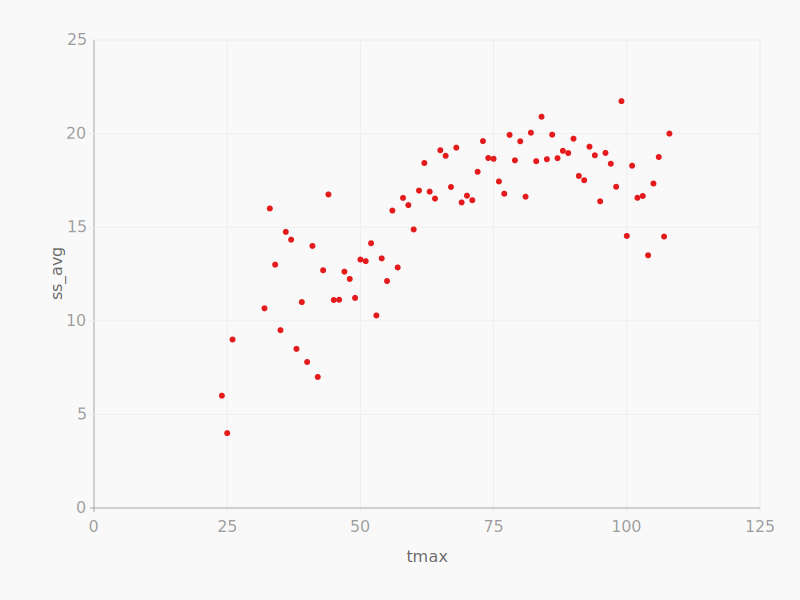

In [17]:
crimes_by_temp.scatterplot('tmax','ss_avg')